# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 13 at 5pm.**

In this assignment, we will be working with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

In [1]:
import ijson
import json
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Getting the data and parsing it to turn it into a dictionary of {key:{dict}}
data = {}
with open('business.json') as f:
    for record in f:
        data[record] = json.loads(record)

# Making it into a datframe of samples x features
df = pd.DataFrame.from_dict(data)
df = df.transpose()
df = df.set_index([list(range(0,len(data)))])

# Counts of each category value to create a subset of most common categories (takes some time to run)
#catcounts = df['categories'].apply(lambda x: pd.Series(x).value_counts()).sum().sort_values(ascending=False)

# df2 is a subset of restaurants in the original dataframe that contains Restaurants that have one of the top 40 categories
# which I manually picked out for 15 food related subcategories
# filtercatx = list(catcounts[1:40].index) 
filtercat = ['Indian', 'Bars', 'Seafood', 'Sandwiches','Fast Food','American (Traditional)','Pizza', 'Coffee & Tea','American (New)',
 'Bakeries', 'Chinese','Breakfast & Brunch','Mexican','Italian','Burgers','Specialty Food','Japanese']
df2 = df[df['categories'].apply(lambda x: ','.join(x)).str.contains('|'.join(['Restaurants']))]
df2 = df2.query('city == "Las Vegas"')
df2 = df2[df2['categories'].apply(lambda x: ','.join(x)).str.contains('|'.join(filtercat))]

# Create a binary vector from the categories - using filtercat as the template, iterate through the column 'categories' and 
# for elements that equate those in filtercat, create a new vector with 1's at the locations of elements in filtercat, 0's 
# elsewhere, substitue into a new dataframe, to be used for clustering
df3 = df2.copy()
for index, row in df2.iterrows():
    x = [i for i, item in enumerate(filtercat) if item in df2.loc[index, 'categories']]
    dummy = np.zeros(len(filtercat))
    for elem in x:
        dummy[elem] = 1
    dummy = dummy.round()
    df3.loc[index,'categories'] = dummy

    # Now we cluster
# First we turn the listed category features into  cloumns of the datafrmae
pt1 = df3[['latitude','longitude']].copy()
pt1[filtercat] = df3['categories'].apply(pd.Series)
# Now turn that to a form recognized by sklearn.kmeans
arraypt1 = np.zeros(len(pt1.columns))
for index, row in pt1.iterrows():
    arraypt1 = np.vstack(((np.asarray(row)),arraypt1))
arraypt1 = np.delete(arraypt1, 4494, axis=0) # array of 0's

C:\Python\lib\site-packages\ipykernel_launcher.py:30: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


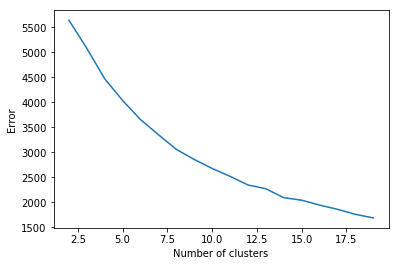

In [2]:
# K-means clustering
# First I determined the amount of scaling to use by observing the amount of clusters change with scaling of clusters
# Location (lat,long) should be affect clusters more than the culinary category. 
# First I plotted with no scaling
def kmeanserr(data):
    error = np.zeros(20)
    for k in range(1,20):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(data)
        error[k] = kmeans.inertia_
    plt.plot(range(2,len(error)),error[2:])
    plt.xlabel('Number of clusters')
    dummy = plt.ylabel('Error')

kmeanserr(arraypt1)



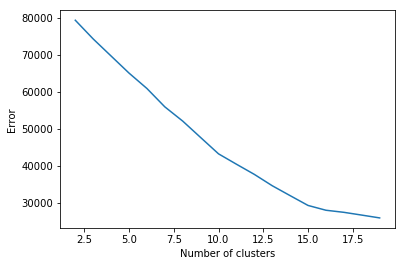

In [3]:
# Now we scale by normalizing the dataframe
import sklearn.preprocessing as pc
scaledpt1 = pc.scale(arraypt1.astype('float64'))

kmeanserr(scaledpt1)
    


Makes sense as location naturally outscales the binary digits for categories, and now that we normalize we have more clusters by looking at the elbow, we should expect <14 clusters as that is where the elbow occurs with no location weights

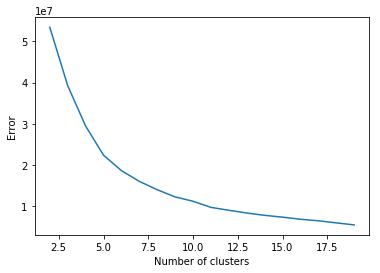

In [4]:
# Now we scale the longitude and latitude by 100 as reference for location dominant clustering
scaledpt2 = scaledpt1*[100,100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

kmeanserr(scaledpt2)


So we should expect >5 clusters, as we are subdividing location clusters into culinary (categories) districts essentially

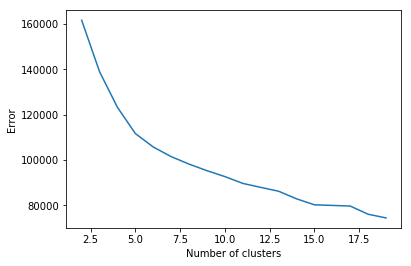

In [5]:
scaledpt2 = scaledpt1*[4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

kmeanserr(scaledpt2)

Its hard to get a clear elbow to show where we are looking for one (between 5 and 14) by tweaking the location weights, so lets look at silhoutte coefficients for well defined clusters

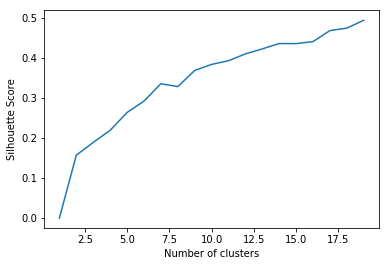

In [6]:
# Now lets try within the same scaling with silhouette coefficients
import sklearn.metrics as metrics

def silkmeans(data):
    s = np.zeros(20)
    for k in range(2,20):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(data)
        s[k] = metrics.silhouette_score(data,kmeans.labels_,metric='euclidean')
    plt.plot(range(1,len(s)),s[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
silkmeans(arraypt1)

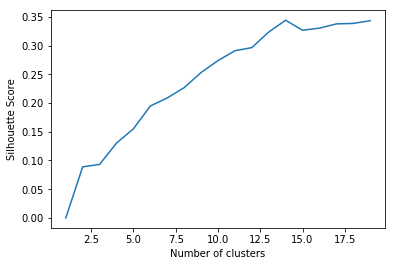

In [7]:
silkmeans(scaledpt1)

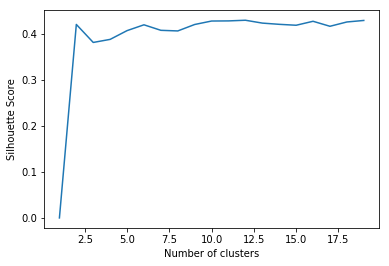

In [8]:
scaledpt2 = scaledpt1*[100,100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

silkmeans(scaledpt2)

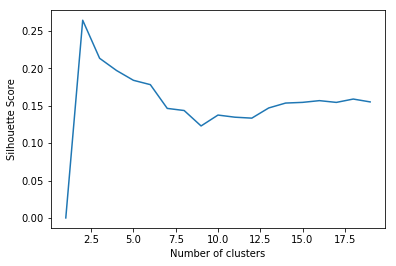

In [9]:
scaledpt2 = scaledpt1*[4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

silkmeans(scaledpt2)

We can see that with inertial error, we can at best get an estimate of how many clusters to expect after scaling location, which we would expect to be betwen 5 (result from location dominant weighting) and 14 (categorical weight = location weight). If we then look at silhoutte coefficients and use the parameters we estimated, we can see there exists a local maximum of 9 with a scaled and location weight of 4. This exists within our parameters and the spike at 2 clusters suggest that the location is dominant enough to influence clustering.

In [10]:
kmeans = KMeans(init='k-means++', n_clusters=9, n_init=100)
kmeans1 = kmeans.fit_predict(scaledpt2)

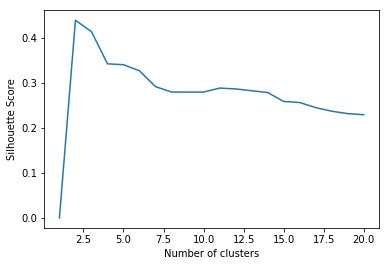

In [11]:
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
max_clusters = 20
Z_20ng = hierarchy.linkage(scaledpt1, method= 'single', metric='euclidean')
s = np.zeros(max_clusters+1)
scaledpt1 = pc.scale(arraypt1.astype('float64'))
for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(Z_20ng, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(scaledpt1,clusters,metric='euclidean')
plt.plot(range(1,len(s)),s[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

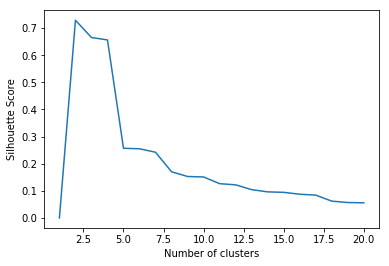

In [12]:
# Now with the location weights
max_clusters = 20
Z_20ng = hierarchy.linkage(scaledpt2, method= 'single', metric='euclidean')
s = np.zeros(max_clusters+1)

for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(Z_20ng, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(scaledpt2,clusters,metric='euclidean')
plt.plot(range(1,len(s)),s[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

I used single as it is the min distance between samples, as would be the "simplest" for pure euclidean distanced restaurants on a longitude/latitude plot.

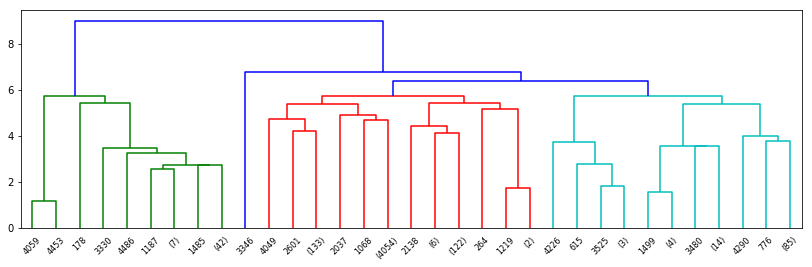

In [13]:
Z_20ng = hierarchy.linkage(scaledpt1, method='single', metric='euclidean')
plt.figure(figsize=(14,4))
R_20ng = hierarchy.dendrogram(Z_20ng, p=6, truncate_mode='level', show_leaf_counts=True)

Argument can be made here that there are 2 clusters, as well as 4 clusters. This is similar to what we saw with the k-means, where arguments can be made for a small amount of clusters (we presume to be the location based) and a large amount (we presume the locations to be divided into categories). 

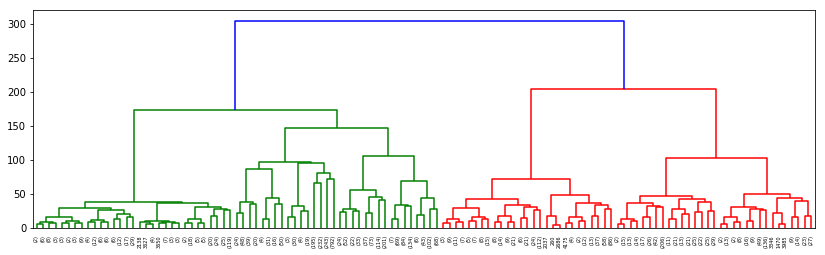

In [14]:
Z_20ng = hierarchy.linkage(scaledpt2, method='ward', metric='euclidean')
plt.figure(figsize=(14,4))
R_20ng = hierarchy.dendrogram(Z_20ng, p=6, truncate_mode='level', show_leaf_counts=True)

As expected, with location weights thrown in the, well defined clusters start springing up. Argument can be made for 2 clusters here as well as 4 and 7-12 clusters, which we can presume is the locations subdivided into categories.

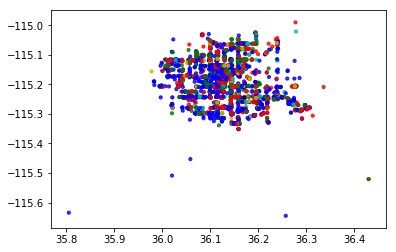

In [219]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=9, covariance_type='full')
gmm.fit(scaledpt2)
y_pred = gmm.predict(scaledpt2)

colors = ['bgrcmykbgrcmykbrcmykbgrcmykb'[p] for p in y_pred]
_ = plt.scatter(arraypt1[:, 0], arraypt1[:, 1], color=colors, s=10, alpha=0.8)

Here the n_components is difficult to identify. We can use th BIC to identify but that erquries us to know the log liklihood which I don't believe we can find out. As GMM is a probalistic approach on K-means, i thus chose the number of clusters in k-means to be the amount of guassians in the n_components

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

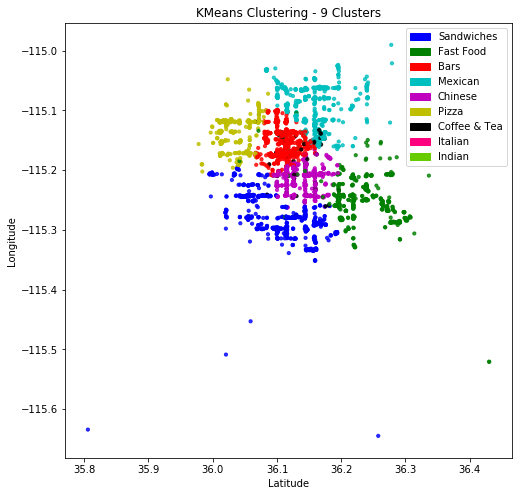

In [345]:
import matplotlib.patches as mpatches

scaledpt2 = scaledpt1*[4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

kmeans = KMeans(init='k-means++', n_clusters=9, n_init=100)
kmeans1 = kmeans.fit_predict(scaledpt2)

# append a new column to scaledpt2, containing the respective cluster label in last column
scaled2clust = np.zeros((scaledpt2.shape[0],scaledpt2.shape[1]+1))
scaled2clust[:,:-1] = scaledpt2
scaled2clust[:,-1] = kmeans1

colors = ['bgrcmykbgrcmykbg'[p] for p in kmeans1]

#groupby cluster (need to be in dataframe) sum the categories, convert back to array
scaled2clust = pd.DataFrame(scaled2clust).groupby(19).sum().values
#find index of largest category excluding lat and long
labels_legend = np.argmax(scaled2clust[:,2:],axis=1)
# label these indices
labels_legend = list(labels_legend)
for i in range(0,len(labels_legend)):
    categ = labels_legend[i] 
    labels_legend[i] = filtercat[categ]
    
bp = mpatches.Patch(color='b', label=labels_legend[0])
gp = mpatches.Patch(color='g', label=labels_legend[1])
rp = mpatches.Patch(color='r', label=labels_legend[2])
cp = mpatches.Patch(color='c', label=labels_legend[3])
mp = mpatches.Patch(color='m', label=labels_legend[4])
yp = mpatches.Patch(color='y', label=labels_legend[5])
kp = mpatches.Patch(color='k', label=labels_legend[6])
pip = mpatches.Patch(color='#FF007F', label=labels_legend[7])
lgp = mpatches.Patch(color='#66CC00', label=labels_legend[8])
#grp = mpatches.Patch(color='#C0C0C0', label=labels_legend[9])

plt.figure(1)
plt.figure(figsize=(8,8))
kmplot =plt.scatter(arraypt1[:, 0], arraypt1[:, 1], color=colors, s=10, alpha=0.8)

plt.legend(handles=[bp,gp,rp,cp,mp,yp,kp,pip,lgp])
plt.title('KMeans Clustering - 9 Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

I assigned these labels by taking the scaled values and finding summing the values in each category for each cluster. This should return the a row containing the summed values of each category for each of the 9 clsuters. You can then pull out the highest category value for each cluster to determine what category had the biggest influence on creating the cluster. This is because they should simply be scaled/normalized binaries, which have 1's for a restaurant with that category and 0's if they don't. As a result summing would effectively "count" the amount of restaurants in that cluster with that category. We simply just pick the highest count and assign that category to the cluster.

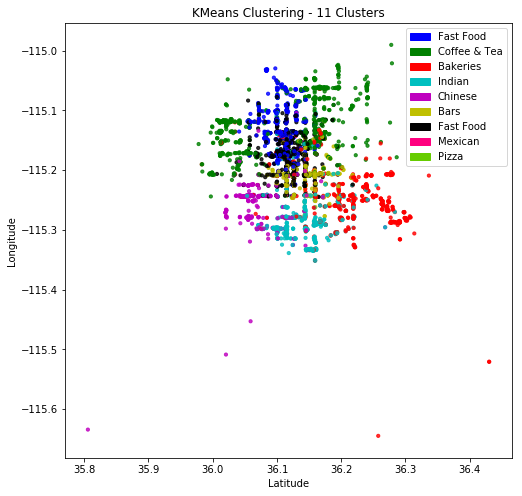

In [346]:
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import mds

fc = fcluster(Z_20ng, 11, criterion='maxclust')

scaled2clust = np.zeros((scaledpt2.shape[0],scaledpt2.shape[1]+1))
scaled2clust[:,:-1] = scaledpt2
scaled2clust[:,-1] = fc

colors = ['bgrcmykbgrcmykbg'[p] for p in fc]

#groupby cluster (need to be in dataframe) sum the categories, convert back to array
scaled2clust = pd.DataFrame(scaled2clust).groupby(19).sum().values
#find index of largest category excluding lat and long
labels_legend = np.argmax(scaled2clust[:,2:],axis=1)
# label these indices
labels_legend = list(labels_legend)
for i in range(0,len(labels_legend)):
    categ = labels_legend[i] 
    labels_legend[i] = filtercat[categ]
                                 
bp = mpatches.Patch(color='b', label=labels_legend[0])
gp = mpatches.Patch(color='g', label=labels_legend[1])
rp = mpatches.Patch(color='r', label=labels_legend[2])
cp = mpatches.Patch(color='c', label=labels_legend[3])
mp = mpatches.Patch(color='m', label=labels_legend[4])
yp = mpatches.Patch(color='y', label=labels_legend[5])
kp = mpatches.Patch(color='k', label=labels_legend[6])
pip = mpatches.Patch(color='#FF007F', label=labels_legend[7])
lgp = mpatches.Patch(color='#66CC00', label=labels_legend[8])
#grp = mpatches.Patch(color='#C0C0C0', label=labels_legend[9])

plt.figure(figsize=(8,8))
hiplot = plt.scatter(arraypt1[:, 0], arraypt1[:, 1], color=colors, s=10, alpha=0.8)

plt.legend(handles=[bp,gp,rp,cp,mp,yp,kp,pip,lgp])
plt.title('KMeans Clustering - 11 Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

Hierarchal is very similar to the k-means in terms of identifying clusters. The labels are different however. I chose cluster labels in much the same way as k-means. I identified with restaurants belonged to which cluster, summed the values of the scaled categories for each cluster, and chose the highest value as the category label for that cluster.

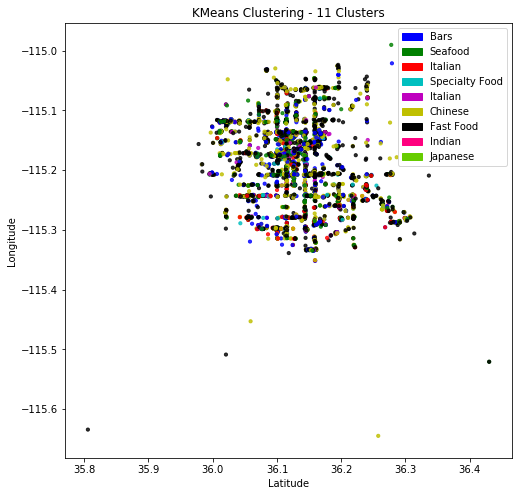

In [347]:
gmm = mixture.GaussianMixture(n_components=9, covariance_type='full')
gmm.fit(scaledpt2)
y_pred = gmm.predict(scaledpt2)

scaled2clust = np.zeros((scaledpt2.shape[0],scaledpt2.shape[1]+1))
scaled2clust[:,:-1] = scaledpt2
scaled2clust[:,-1] = y_pred

colors = ['bgrcmykbgrcmykbg'[p] for p in y_pred]

#groupby cluster (need to be in dataframe) sum the categories, convert back to array
scaled2clust = pd.DataFrame(scaled2clust).groupby(19).sum().values
#find index of largest category excluding lat and long
labels_legend = np.argmax(scaled2clust[:,2:],axis=1)
# label these indices
labels_legend = list(labels_legend)
for i in range(0,len(labels_legend)):
    categ = labels_legend[i] 
    labels_legend[i] = filtercat[categ]
                                 
bp = mpatches.Patch(color='b', label=labels_legend[0])
gp = mpatches.Patch(color='g', label=labels_legend[1])
rp = mpatches.Patch(color='r', label=labels_legend[2])
cp = mpatches.Patch(color='c', label=labels_legend[3])
mp = mpatches.Patch(color='m', label=labels_legend[4])
yp = mpatches.Patch(color='y', label=labels_legend[5])
kp = mpatches.Patch(color='k', label=labels_legend[6])
pip = mpatches.Patch(color='#FF007F', label=labels_legend[7])
lgp = mpatches.Patch(color='#66CC00', label=labels_legend[8])
#grp = mpatches.Patch(color='#C0C0C0', label=labels_legend[9])

plt.figure(figsize=(8,8))
plt.scatter(arraypt1[:, 0], arraypt1[:, 1], color=colors, s=10, alpha=0.8)

plt.legend(handles=[bp,gp,rp,cp,mp,yp,kp,pip,lgp])
plt.title('KMeans Clustering - 11 Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')


So this is just a mess, this is probably due to the fact the GMM is based on the underlying assumption that the samples were drawn from a guassian dsitrbution, which is not true. Restaurants don't place themselves or list themselves on yelp on a guassian distribution.

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

To find the outliers we must identify which restaurants (samples) belong to which clusters. Then we iterate through those restaurants on a cluster by cluster basis to identify which restaurant is the furthest. We can determine furthest by euclidean distance of restaurants between all dimensions (features/category) from the centroid of the respective cluster that restaurant bleongs in. This will give us the outliers in a near list. You can certainly visually see outliers on the scatterplots above. I would almost 100% expect these outliers to exist due to location (latitude/longitude) on the hierarchal and k-means clustering. The GMM outliers seem to exist to random points and I would expect far more extreme outliers to GMM as a result.

In [384]:
# K-means outliers
from scipy.spatial import distance
scaled2clust = np.zeros((scaledpt2.shape[0],scaledpt2.shape[1]+1))
scaled2clust[:,:-1] = scaledpt2
scaled2clust[:,-1] = kmeans1

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

pt3 = pd.DataFrame(scaled2clust).sort_values(19)
# outliers for each cluster [pt3[19] == N]
def outlier(cluster):
    dist = {}
    for index, row in pt3[pt3[19] == cluster].iterrows():
        dist[index] = distance.euclidean(centroids[0],row[:-1])

    distlist = []
    for key, value in dist.items():
        temp = [key,value]
        distlist.append(temp)
    maxdist = sorted(distlist,key=lambda x: x[1],reverse=True)
    temp = pt3.loc[maxdist[0][0]]
    return temp
outlier0 = outlier(0)
outlier1 = outlier(1)
outlier2 = outlier(2)
outlier3 = outlier(3)
outlier4 = outlier(4)
outlier5 = outlier(5)
outlier6 = outlier(6)
outlier7 = outlier(7)
outlier8 = outlier(8)

As hypothesized, a good amount of the outliers exist due to the lat/long distance. This is apparent by a side by side comparison of each of the outliers with the other points in the cluster

In [382]:
# Hierarchal outliers
scaled2clust = np.zeros((scaledpt2.shape[0],scaledpt2.shape[1]+1))
scaled2clust[:,:-1] = scaledpt2
scaled2clust[:,-1] = fc

pt3 = pd.DataFrame(scaled2clust).sort_values(19)

centroids = pt3.groupby(19).mean()

# outliers for each cluster [pt3[19] == N]
def outlier(cluster):
    dist = {}
    for index, row in pt3[pt3[19] == cluster].iterrows():
        dist[index] = distance.euclidean(centroids.iloc[0],row[:-1])

    distlist = []
    for key, value in dist.items():
        temp = [key,value]
        distlist.append(temp)
    maxdist = sorted(distlist,key=lambda x: x[1],reverse=True)
    temp = pt3.loc[int(maxdist[0][0])]
    return temp
Houtlier11 = outlier(11)
Houtlier1 = outlier(1)
Houtlier2 = outlier(2)
Houtlier3 = outlier(3)
Houtlier4 = outlier(4)
Houtlier5 = outlier(5)
Houtlier6 = outlier(6)
Houtlier7 = outlier(7)
Houtlier8 = outlier(8)
Houtlier8 = outlier(9)
Houtlier8 = outlier(10)

Similarly to k-means you can see the outliers are largely influenced by long/lat distance from the rest of the cluster,  categories seem to have a slight affect as well when compared to the cluster label on the scatterplots

In [385]:
gmm = mixture.GaussianMixture(n_components=9, covariance_type='full')
gmm.fit(scaledpt2)
y_pred = gmm.predict(scaledpt2)

scaled2clust = np.zeros((scaledpt2.shape[0],scaledpt2.shape[1]+1))
scaled2clust[:,:-1] = scaledpt2
scaled2clust[:,-1] = y_pred

pt3 = pd.DataFrame(scaled2clust).sort_values(19)

centroids = pt3.groupby(19).mean()

# outliers for each cluster [pt3[19] == N]
def outlier(cluster):
    dist = {}
    for index, row in pt3[pt3[19] == cluster].iterrows():
        dist[index] = distance.euclidean(centroids.iloc[0],row[:-1])

    distlist = []
    for key, value in dist.items():
        temp = [key,value]
        distlist.append(temp)
    maxdist = sorted(distlist,key=lambda x: x[1],reverse=True)
    temp = pt3.loc[maxdist[0][0]]
    return temp
Goutlier0 = outlier(0)
Goutlier1 = outlier(1)
Goutlier2 = outlier(2)
Goutlier3 = outlier(3)
Goutlier4 = outlier(4)
Goutlier5 = outlier(5)
Goutlier6 = outlier(6)
Goutlier7 = outlier(7)
Goutlier8 = outlier(8)

Give a detailed analysis comparing the results you obtained from the 3 rechniques (10pts)

The clustering using euclidean distance (k-means or hierarchal) seems to yield similar results, as to be expected. The GMM yields wildly differnet results with poor clustering. This is to be expected as the restaurants do not disperse themselves in a guassian distribution as the GMM model expects. Furthermore, as GMM is a probabilistic model, these points assigned to the labels could easily be P(c1 l x) = 0.51 and P(c2 l x) = 0.49, causing it to be assigned to cluster 1. This could be the cause for the poor clustering we see on the scatterplots. The two classes of methods also yielded different amounts of clusters as well. If I were to compare the three I would say for this situation, hierarchal and k-means definitely shown through. Looking at the hierachal dendrograms definitely provided easier assessments of the correct amount of clusters, as it includes information as to how far apart clusters, and the points within the clusters, are from other clusters. This is not present in k-means, and we must estimate the cluster count by seeing the inertial error (how fast the clusters are changing) with each iteration. It would be nice if I could properly label the restaurants by cluster as we can get far more interesting results/points afterwards by identifying outliers and cluster sizes and whatnot. 

----------